# Sensitivity analysis on models governed by stochastic fields :
## Analysis & Validation

- Date: 14.10.20
- Author: K. A. Simady 

##### Aim of the notebook : present the methods already developed as well as a simple example, and compare the already known methods to the ones developed. 
- **Theme :** Sensitivity analysis of models taking as an input scalar random variables, as well as random stochastic fields. 
- **Example :** Model of a beam being supported on both ends and subject to a point force. Five quantities are subject to uncertainties : 
    - The diameter D_ of the section of the beam is varying along a one dimensional field along the axis of the beam. 
    - The Young Modulus E_ is also varying stochastically along the same axis
    - The position of the application point of the force FPos is following a scalar normal law centered on the beams middle point. 
    - The norm of the force vector FNorm is also follwing a scalar normal law centered around 100N 
    - The global densitiy of the beam which is also determined by a scalar normal law centered around the materials real density
- **Method :** Roughly, the method consist in reexpressing the model (which was taking as inputs **Fields** & **Scalars**) as a new model only dependent of a **Scalar vector**. This is made possible through the usage of the **Karhunen-Loeve decomposition**, thanks to which one can freely express a field generated by a stochastic process of known parameters as a vector of scalars. This decomposition is analogous to the **Fourier** decomposition. Once the model is re-expressed a metamodel is built using either krieging or polynomial chaos. Then the sensitivity analysis is done on this metamodel, in hope that it behaves as the real model. This will be tested here.
- **Application :** This method is developed to be used to analyse the model of a aeronautics grade heat exchanger, but this example will not be presented here. 

In [1]:
# Let's first import the necessary modules. 
# Base modules :
import os
from collections.abc import Sequence, Iterable
import numpy as np
import openturns as ot
import pandas as pd
# Phimeca's modules :
import pythontools as pt # tools created for krieging, pce and other stuff... 
# Own modules : 
import KarhunenLoeveFieldSensitivity as klfs # integration of the codes developed ... 
# Example Model :
import PureBeamExample as MODEL # Could be any model really... 


Bad key "text.kerning_factor" on line 4 in
/home/simady/anaconda/envs/stochastic_field_env/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


- The inputs to our model are the 5 uncertain variables, which effects we try to measure. As for the Karhunen-Loeve decomposition the parameters of the stochastic process must be known (scale, amplitude, autocorrelation function) we will first define those. 
- Only two of our 5 inputs are stochastic fields, but we need to also express the other ones as fields. To achieve this, we can think about a scalar as the first value of a constant stochastic_field. 

In [2]:
# Let's define a function that transforms a scalar random law and a mesh into a constant stochastic process : 
# Not necessary anymore
def distributionOnMesh(distribution, mesh):
    '''Function to transform a scalar distribution into 
    a constant process defined over a mesh
    '''
    basis = ot.Basis([ot.SymbolicFunction(['x'],['1'])])
    distributionOnMesh = ot.FunctionalBasisProcess(distribution, basis, mesh)
    distributionOnMesh.setName(distribution.getName())
    return distributionOnMesh

##### Let's define our processes :
- As only the autocovariance function and the mesh is needed for the **Karhunen Loeve** decomposition, we have no need to neither define our gaussian processes nor to set a trend function. This has some implications :
    - **The trend function was as a constant to represent the mean value of our process. As it is no longer present, in the decomposition, we have to directly add the means inside of our model and consider the inputs as sole perturbations of the mean.**

In [3]:
# Let's first define the mesh, as it is the same for all the processes, random variables and the finite elements of the beam itself. 
dimension = 1
NElem = [100]
mesher = ot.IntervalMesher(NElem)
lowerBound = [0] #mm
upperBound = [1000] #mm
interval = ot.Interval(lowerBound,upperBound)
mesh = mesher.build(interval)
# 100 elements of 10 mm


In [4]:
# First process decomposition : Stochastic young's modulus 
amplitude0 = [50000]*dimension # Mean : 210000 MPaa
scale0 = [300]*dimension 
nu0 = 13/3
model0 = ot.MaternModel(scale0, amplitude0, nu0)

process=ot.GaussianProcess(model0, mesh)

# Karhunen Loeve decomposition of process 
algorithm = ot.KarhunenLoeveP1Algorithm(mesh, model0, 1e-3)
algorithm.setNbModes(6)
algorithm.run()
resultsE = algorithm.getResult()
resultsE.setName('E_')
resultsE.getCovarianceModel()

class=MaternModel scale=class=Point name=Unnamed dimension=1 values=[300] amplitude=class=Point name=Unnamed dimension=1 values=[50000] nu=4.33333

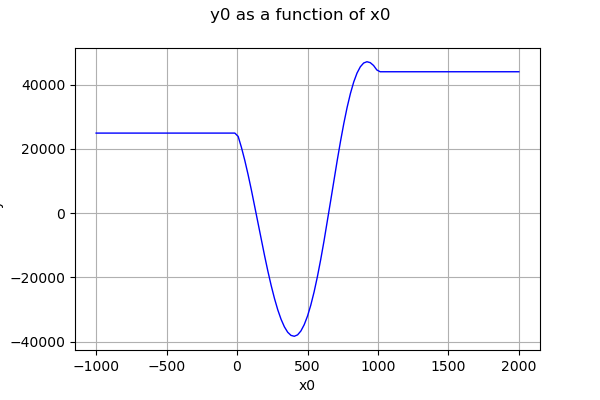

In [18]:
ot.RandomGenerator_SetSeed(0)
rea = process.getRealization()
x = resultsE.project(rea)
f = resultsE.lift(x)
f.draw([-1000],[2000])


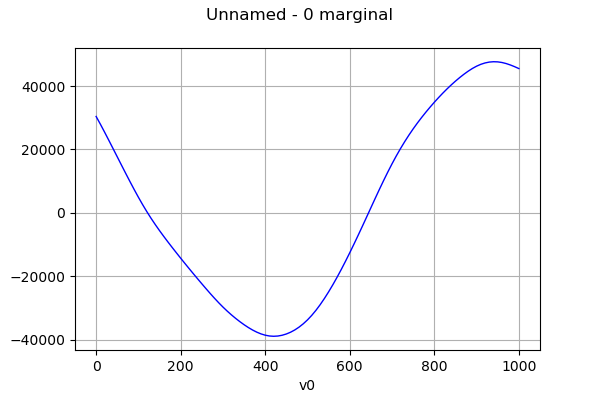

In [6]:
rea.drawMarginal()

In [7]:
# Second process decomposition : Stochastic Diameter
amplitude = [.3]*dimension # Mean 10 mm
scale = [250]*dimension
nu = 7.4/3
model1 = ot.MaternModel(scale, amplitude, nu)
algorithm = ot.KarhunenLoeveP1Algorithm(mesh, model1, 1e-3)
algorithm.setNbModes(6)
algorithm.run()
resultsD = algorithm.getResult()
resultsD.setName('D_')

In [8]:
# The three scalar random variables : 
# random variable for the density of the material (kg/m³)
sigma       = 750
RV_Rho = ot.Normal(7850, sigma)
RV_Rho.setName('Rho')
# random variable for the position of the force (mm) 
sigma_f      = 50
RV_Fpos = ot.Normal(500, sigma_f)
RV_Fpos.setName('FPos')
# random variable for the norm of the force (N)
sigma_Fnor    = 5.5
RV_Fnorm  = ot.Normal(100, sigma_Fnor)
RV_Fnorm.setName('FNorm')

# With the modifs, we can now utilize directly the Distributions

#### Once all the processes are defined, created and decomposed thanks to Karhunen Loeve, we use our newly created class **AggregatedKarhunenLoeveResults**. This class is the link between our reduced normal centered law vector, being one dimensional, and our dimension of arbitrary fields and scalars (so either a-dimensional or multi-dimensional). 

In [9]:
listOfKLRes = [resultsE, resultsD, RV_Rho, RV_Fpos, RV_Fnorm]
AggregatedKLRes = klfs.AggregatedKarhunenLoeveResults(listOfKLRes)
AggregatedKLRes.setMean(0, 210000) # At other indices the means are initialized from the distributions
AggregatedKLRes.setMean(1, 10) 
AggregatedKLRes.setLiftWithMean(True)

The mean value of distribution at index 2 of type Normal is not 0.
Distribution recentered and mean added to list of means
Set the "liftWithMean" flag to true if you want to include the mean.
The mean value of distribution at index 3 of type Normal is not 0.
Distribution recentered and mean added to list of means
Set the "liftWithMean" flag to true if you want to include the mean.
The mean value of distribution at index 4 of type Normal is not 0.
Distribution recentered and mean added to list of means
Set the "liftWithMean" flag to true if you want to include the mean.
The process names are not unique.
Using generic name. 
Old name was E_, new one is X_0
Old name was D_, new one is X_1
Old name was Normal, new one is X_2
Old name was Normal, new one is X_3
Old name was Normal, new one is X_4


###### Depending on how our model was defined, some more steps may be performed if necessary. In our case, to initialize our model, we first have to pass it a mesh from which dimensions it builds its finite element representation, entirely based on the mesh on which the processes where defined. Then we differentiate our model into two functions, one that works on multiple inputs with multiprocessing and one only for single evaluations. **This differntation step is optional, only one of the two functions is needed**
- **The functions as well as the aggregated Karhunen Loeve Results object are passed to a other newly defined class: KarhunenLoeveGeneralizedFunctionWrapper :
    > As this class has access to the Karhunen-Loeve decomposition (which is as said the link between our differnt dimensions) and the model to analyse, this wrapper allows us to get a other view of the model, a view where the model is only dependent of a input vector of values following a centered reduced normal law.

In [10]:
# definition of the model :
_MODEL = MODEL.PureBeam(mesh)

# initialization of the function wrapper : 
FUNC = klfs.KarhunenLoeveGeneralizedFunctionWrapper(
                                AggregatedKarhunenLoeveResults = AggregatedKLRes,
                                func        = _MODEL.singleEval, 
                                func_sample = _MODEL.batchEval,
                                n_outputs   = 2) #We have to define the number of elements in the tuple the model returns !!!!!!!!!!!

#### Now that we have defined our model and input parameters we can begin to design our DOE (Design of experiment). We will generate mutiple DOEs, as we want to compare multiple methods together. 
- **As we know that ALL the components of the vector entering into our wrapped functions are following a centered resuced normal law we have different ways of generating our DOE.**
    - First of all we need 3 types of DOEs :
        - One for the krieging with 100 points : This one will be generated with the LHS sampling method. For this generation we do not need any class in particular. 
            - => For this sample we also need the response (or output) of the finite element model (FUNC) 
        - Two for the calculus of the sobol indices. These ones will be much bigger and will only follow a random sampling method. Only one of these samples will be evaluated on the finite element model. The other one will be evaluated on the krieging metamodel to compare the sobol indices in both cases. 
    - As we want to test the inluence of the different parameters having an influence we will prepaper multiple DOEs per type of DOE. :
        - For the first type (the krieging model):
            - one DOE with 50 points following the LHS sampling method    | SEED : 130875 => CALCULUS OF THE FEM MODEL RESPONSE
            - one DOE with 100 points following the LHS sampling method   | SEED : 409484 => CALCULUS OF THE FEM MODEL RESPONSE
            - one DOE with 200 points following the LHS sampling method   | SEED : 224409 => CALCULUS OF THE FEM MODEL RESPONSE

        - For the second and third type (sobol on the fem model):
            - one DOE with 1000 points following a random sampling method | SEED : 248214 => CALUCLUS OF THE FEM MODEL RESPONSE
            - one DOE with 2000 points following a random sampling method | SEED : 720442 => CALUCLUS OF THE FEM MODEL RESPONSE
            - one DOE with 4000 points following a random sampling method | SEED : 109242 => CALUCLUS OF THE FEM MODEL RESPONSE



In [11]:
import functools
import time
def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        tic = time.perf_counter()
        value = func(*args, **kwargs)
        toc = time.perf_counter()
        elapsed_time = toc - tic
        print(f"Elapsed time: {elapsed_time:0.4f} seconds")
        return value
    return wrapper_timer


# Little helper class for optimized lhs :
@timer
def optimizedLHS(distribution, size, seed):
    ot.RandomGenerator.SetSeed(seed)
    lhs = ot.LHSExperiment(distribution, size, True, True)
    lhs_optimise = ot.SimulatedAnnealingLHS(lhs)
    lhs_sample = lhs_optimise.generate()
    return lhs_sample

@timer
def getSample(distribution, size, seed):
    ot.RandomGenerator.SetSeed(seed)
    sample = distribution.getSample(size)
    sample.setDescription(distribution.getDescription())
    return sample

@timer 
def getSobolExperiment(size, seed, secondOrder = False):
    ot.RandomGenerator.SetSeed(seed)    
    experiment = klfs.KarhunenLoeveSobolIndicesExperiment(AggregatedKLRes, size, secondOrder)
    sobolExp = experiment.generate()
    return sobolExp, experiment



To build our design of experiment, we will need some data about our KL decomposition, namely the order of decomposition and a random normal vector

In [12]:
nModes = AggregatedKLRes.getSizeModes()  # the number of elements in the input vector of our KL wrapped model
randNormVect = ot.ComposedDistribution([ot.Normal()] * nModes)  # 
randNormVect.setDescription(AggregatedKLRes._getModeDescription())

In [13]:
kg_doe50_130875   = optimizedLHS(randNormVect, 50, 130875)
kg_doe100_409484  = optimizedLHS(randNormVect, 100, 409484)
kg_doe200_224409  = optimizedLHS(randNormVect, 200, 224409)
print('First DOE type done\n')

si_doe1000_248214, expe_doe1000 = getSobolExperiment(1000, 248214)
si_doe2000_720442, expe_doe2000 = getSobolExperiment(2000, 720442)
si_doe4000_109242, expe_doe4000 = getSobolExperiment(4000, 109242)
si_doe8000_439038, expe_doe8000 = getSobolExperiment(8000, 439038)

si_sec_doe2000_8291001288, expe_doe2000_sec = getSobolExperiment(2000, 8291001288, True)

print('Sobol Samples OK.')

valid_doe200_502849 = optimizedLHS(randNormVect, 200, 502849)

Elapsed time: 0.4755 seconds
Elapsed time: 1.2602 seconds
Elapsed time: 3.4164 seconds
First DOE type done

Samples A and B of size 1000 and dimension 15
Experiment of size 7000 and dimension 15
Elapsed time: 0.0069 seconds
Samples A and B of size 2000 and dimension 15
Experiment of size 14000 and dimension 15
Elapsed time: 0.0136 seconds
Samples A and B of size 4000 and dimension 15
Experiment of size 28000 and dimension 15
Elapsed time: 0.0301 seconds
Samples A and B of size 8000 and dimension 15
Experiment of size 56000 and dimension 15
Elapsed time: 0.0668 seconds
Generating samples for the second order indices
Samples A and B of size 2000 and dimension 15
Experiment for second order generated
Experiment of size 24000 and dimension 15
Elapsed time: 0.0238 seconds
Sobol Samples OK.
Elapsed time: 3.9685 seconds


#### Now that we have defined our design of expriments, we're going to evaluate the model on them, to get it's response. Then we're going to all save into csv files in  a folder, and use these as a basis for our analysis

In [14]:
DOE_names      = ['kg_doe50_130875', 'kg_doe100_409484', 'kg_doe200_224409', 'si_doe1000_248214', 'si_doe2000_720442', 
                  'val_doe200_502849', 'si_sec_doe2000_8291001288' , 'si_doe4000_109242', 'si_doe8000_439038']
DOE_resp_names = ['kg_doe50_130875_resp', 'kg_doe100_409484_resp', 'kg_doe200_224409_resp', 'si_doe1000_248214_resp', 'si_doe2000_720442_resp', 
                  'val_doe200_502849_resp', 'si_sec_doe2000_8291001288_resp', 'si_doe4000_109242_resp', 'si_doe8000_439038_resp']

In [15]:
l_DOEs = [kg_doe50_130875,kg_doe100_409484,kg_doe200_224409,si_doe1000_248214,si_doe2000_720442, valid_doe200_502849, si_sec_doe2000_8291001288] #, si_doe4000_109242, si_doe8000_439038] 

In [16]:
folder = './DOE_RESP'
for i, doe in enumerate(l_DOEs):
    if os.path.isfile(os.path.join(folder,DOE_names[i]+'.csv')):
        resp = FUNC(doe)
        vonMises = ot.Sample(np.array(np.stack([np.squeeze(np.asarray(resp[0][i])) for i in range(len(resp[0]))]))) 
        maxDefl = resp[1]
        doe.exportToCSVFile(os.path.join(folder,DOE_names[i]+'.csv'), ';')
        vonMises.exportToCSVFile(os.path.join(folder,DOE_resp_names[i]+'_VM'+'.csv'), ';')
        maxDefl.exportToCSVFile(os.path.join(folder,DOE_resp_names[i]+'_MD'+'.csv'), ';')

Lifting as process sample
field E shape (50, 101)
var_Fnor shape (50,)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.7s finished
/home/simady/anaconda/envs/pythontools/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


shape deflection:  (50, 103)  should be [N,10X] something
deflection std deviation  6.091559783655204
Using the batch evaluation function. Assumes that the outputs are in the 
same order than for the single evaluation function. This one should only 
return ProcessSamples, Samples, Lists or numpy arrays.
Element is iterable, assumes that first dimension is size of sample
Shape is (50, 102) and dtype is <class 'numpy.float64'>
Element 0 of the output tuple returns process samples of dimension 1
Element is iterable, assumes that first dimension is size of sample
Shape is (50,) and dtype is <class 'numpy.float64'>
Element 1 of the output tuple returns samples of dimension 1
Lifting as process sample
field E shape (100, 101)
var_Fnor shape (100,)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.6s finished
/home/simady/anaconda/envs/pythontools/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with d

shape deflection:  (100, 103)  should be [N,10X] something
deflection std deviation  5.900139726165215
Using the batch evaluation function. Assumes that the outputs are in the 
same order than for the single evaluation function. This one should only 
return ProcessSamples, Samples, Lists or numpy arrays.
Element is iterable, assumes that first dimension is size of sample
Shape is (100, 102) and dtype is <class 'numpy.float64'>
Element 0 of the output tuple returns process samples of dimension 1
Element is iterable, assumes that first dimension is size of sample
Shape is (100,) and dtype is <class 'numpy.float64'>
Element 1 of the output tuple returns samples of dimension 1
Lifting as process sample
field E shape (200, 101)
var_Fnor shape (200,)


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.8s
[Paralle

shape deflection:  (200, 103)  should be [N,10X] something
deflection std deviation  6.305960482330019
Using the batch evaluation function. Assumes that the outputs are in the 
same order than for the single evaluation function. This one should only 
return ProcessSamples, Samples, Lists or numpy arrays.
Element is iterable, assumes that first dimension is size of sample
Shape is (200, 102) and dtype is <class 'numpy.float64'>
Element 0 of the output tuple returns process samples of dimension 1
Element is iterable, assumes that first dimension is size of sample
Shape is (200,) and dtype is <class 'numpy.float64'>
Element 1 of the output tuple returns samples of dimension 1
Lifting as process sample
field E shape (7000, 101)
var_Fnor shape (7000,)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

shape deflection:  (7000, 103)  should be [N,10X] something
deflection std deviation  nan
Using the batch evaluation function. Assumes that the outputs are in the 
same order than for the single evaluation function. This one should only 
return ProcessSamples, Samples, Lists or numpy arrays.
Element is iterable, assumes that first dimension is size of sample
Shape is (7000, 102) and dtype is <class 'numpy.float64'>
Element 0 of the output tuple returns process samples of dimension 1
Element is iterable, assumes that first dimension is size of sample
Shape is (7000,) and dtype is <class 'numpy.float64'>
Element 1 of the output tuple returns samples of dimension 1
Lifting as process sample
field E shape (14000, 101)
var_Fnor shape (14000,)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1838s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 300 tas

shape deflection:  (14000, 103)  should be [N,10X] something
deflection std deviation  nan
Using the batch evaluation function. Assumes that the outputs are in the 
same order than for the single evaluation function. This one should only 
return ProcessSamples, Samples, Lists or numpy arrays.
Element is iterable, assumes that first dimension is size of sample
Shape is (14000, 102) and dtype is <class 'numpy.float64'>
Element 0 of the output tuple returns process samples of dimension 1
Element is iterable, assumes that first dimension is size of sample
Shape is (14000,) and dtype is <class 'numpy.float64'>
Element 1 of the output tuple returns samples of dimension 1
Lifting as process sample
field E shape (200, 101)
var_Fnor shape (200,)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

shape deflection:  (200, 103)  should be [N,10X] something
deflection std deviation  6.50521820784113
Using the batch evaluation function. Assumes that the outputs are in the 
same order than for the single evaluation function. This one should only 
return ProcessSamples, Samples, Lists or numpy arrays.
Element is iterable, assumes that first dimension is size of sample
Shape is (200, 102) and dtype is <class 'numpy.float64'>
Element 0 of the output tuple returns process samples of dimension 1
Element is iterable, assumes that first dimension is size of sample
Shape is (200,) and dtype is <class 'numpy.float64'>
Element 1 of the output tuple returns samples of dimension 1
Lifting as process sample
field E shape (24000, 101)
var_Fnor shape (24000,)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

[Parallel(n_jobs=-1)]: Done 9105 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 9240 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 9377 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 9514 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 9653 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 9933 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 10074 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 10217 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 10360 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 10505 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 10650 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 10797 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 10944 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 11093 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 11242 tasks      | 

shape deflection:  (24000, 103)  should be [N,10X] something
deflection std deviation  nan
Using the batch evaluation function. Assumes that the outputs are in the 
same order than for the single evaluation function. This one should only 
return ProcessSamples, Samples, Lists or numpy arrays.
Element is iterable, assumes that first dimension is size of sample
Shape is (24000, 102) and dtype is <class 'numpy.float64'>
Element 0 of the output tuple returns process samples of dimension 1
Element is iterable, assumes that first dimension is size of sample
Shape is (24000,) and dtype is <class 'numpy.float64'>
Element 1 of the output tuple returns samples of dimension 1
